🖼️ Loaded Image: (1080, 1920, 3)
🏛️ Initializing Classical ORB Detector (Aggressive Mode)...
✅ Loaded ORB Reference from /Users/dariusgiannoli/Desktop/Recognition-BenchMark/models/orb_reference.pkl
✅ ORB Detector Loaded.

🚀 Starting Scan with ORB (Classical)...

🔬 BENCHMARK: ORB (Classical)
Total Time:      1.0491s
Latency/Window:  1.7141ms
Detections:      7
🚀 Speedup Factor vs ResNet: 3.0x FASTER


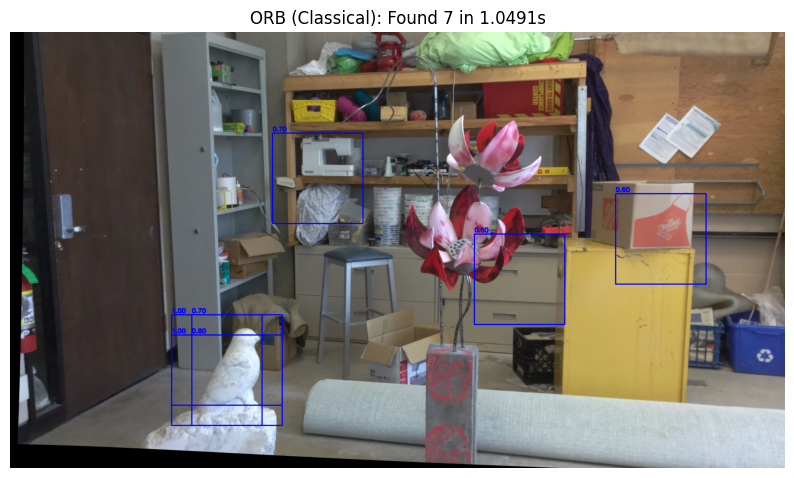

In [1]:
import sys
import os
import cv2
import time
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Setup Path
PROJECT_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJECT_ROOT))

from src.detectors.orb import ORBDetector

# ====================================================
# 2. DEFINE SCANNER (Inline for Safety)
# ====================================================
class BruteForceScanner:
    def __init__(self, step_size=50, window_size=(224, 224), conf_threshold=0.5):
        # Note: Lower threshold for ORB because it's not a probability
        self.step_size = step_size
        self.window_size = window_size
        self.conf_threshold = conf_threshold

    def run(self, image, model, model_name="Unknown"):
        window_w, window_h = self.window_size
        detections = []
        total_windows = 0
        
        print(f"\n🚀 Starting Scan with {model_name}...")
        t0 = time.perf_counter()

        for y in range(0, image.shape[0] - window_h, self.step_size):
            for x in range(0, image.shape[1] - window_w, self.step_size):
                total_windows += 1
                window = image[y:y + window_h, x:x + window_w]
                
                # PREDICT
                label, conf, _ = model.predict(window)
                
                # Filter
                if label == 'bird' and conf > self.conf_threshold:
                    detections.append((x, y, conf))

        t1 = time.perf_counter()
        total_time = t1 - t0
        
        return {
            "model": model_name,
            "detections": detections,
            "total_windows": total_windows,
            "total_time_sec": total_time,
            "ms_per_window": (total_time / total_windows) * 1000 if total_windows > 0 else 0
        }

    def visualize(self, image, results):
        img_copy = image.copy()
        for (x, y, conf) in results['detections']:
            # Blue Box for Classical CV
            cv2.rectangle(img_copy, (x, y), (x + 224, y + 224), (255, 0, 0), 2)
            cv2.putText(img_copy, f"{conf:.2f}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
        plt.title(f"{results['model']}: Found {len(results['detections'])} in {results['total_time_sec']:.4f}s")
        plt.axis('off')
        plt.show()

# ====================================================
# 3. RUN BENCHMARK
# ====================================================
img_path = PROJECT_ROOT / "data/artroom/im0.png"
img = cv2.imread(str(img_path))

if img is None:
    print("❌ Error: Image not found.")
else:
    print(f"🖼️ Loaded Image: {img.shape}")

    try:
        # A. Load ORB
        model = ORBDetector()
        print("✅ ORB Detector Loaded.")
        
        # B. Run Scan
        # Note: We use the same stride (50) as Deep Learning models for fairness
        scanner = BruteForceScanner(step_size=50, window_size=(224, 224), conf_threshold=0.4)
        results = scanner.run(img, model, model_name="ORB (Classical)")
        
        # C. Print Results
        print("\n" + "="*40)
        print(f"🔬 BENCHMARK: {results['model']}")
        print("="*40)
        print(f"Total Time:      {results['total_time_sec']:.4f}s")
        print(f"Latency/Window:  {results['ms_per_window']:.4f}ms")
        print(f"Detections:      {len(results['detections'])}")
        print("="*40)
        
        # Calculate Speedup vs ResNet (3.11s)
        resnet_time = 3.11
        if results['total_time_sec'] > 0:
            speedup = resnet_time / results['total_time_sec']
            print(f"🚀 Speedup Factor vs ResNet: {speedup:.1f}x FASTER")
            
        scanner.visualize(img, results)
        
    except Exception as e:
        print(f"❌ Error: {e}")
        print("Did you run 'python training/train_orb.py'?")